In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Propagación de incertezas con variables correlacionadas

Asumimos que tenemos dos funciones $f_1(x_1, \dots, x_N)$ y $f_2(x_1, \dots, x_N)$ de variables aleatorias $x_1, \dots , x_N$. Las incertidumbres de dichas variables aleatorias están definidas a través de su matríz de covarianza $Cov(x_i, x_j)$

La fórmula más general para la propagación de incertezas (a primer orden) es:

\begin{equation}
Cov(f_1, f_2) = \sum_{i=1}^{N}\sum_{j=1}^N \frac{\partial f_1}{\partial x_i} \frac{\partial f_2}{\partial x_j} Cov(x_i, x_j)
\end{equation}


### Ejemplo: una función que depende de variables aleatorias no correlacionadas

En este caso $f_1=f_2=f(x_1, \dots, x_N)$ y al no estar correlacionadas $Cov(x_i, y_j)=\delta_{ij}\sigma_i^2$ donde $\sigma_i$ es la desviación estándar de $x_i$.

Reemplazando esto en la fómrmula general:

\begin{align}
Cov(f, f) = \sigma^2_f &= \sum_{i=1}^{N}\sum_{j=1}^N \frac{\partial f}{\partial x_i} \frac{\partial f}{\partial x_j} \delta_{ij} \sigma_i^2 \\
   \sigma^2_f &= \sum_{i=1}^N \left( \frac{\partial f}{\partial x_i} \right)^2 \sigma_i^2
\end{align}

Como ejemplo concreto, se puede pensar en una función que sea suma de variables aleatorias $x_i$:

\begin{equation}
f = \sum_i^N x_i
\end{equation}

En este caso, aplicando la fórmula de propagación se obtiene:

\begin{equation}
\sigma_f^2 = \sum_i^N \sigma_i^2
\end{equation}

que es la conocida fórmula de suma en cuadratura de las incertezas de cada variable.

## Aplicación: calibración de un instrumento

Mediante el siguiente ejemplo se podrá apreciar mejor la importancia de propagar las incertidumbres con sus respectivas correlaciones.

Consiste en un caso típico de calibración de un instrumento mediante un modelo lineal. Los pasos a realizar serían los siguientes:

1) Se realizan mediciones para la calibración
2) Se ajusta mediante un modelo lineal
3) Se utiliza el resultado del ajuste para obtener el valor de una nueva medición

Se simulará este proceso en cada uno de estos puntos.
 
### 1) Mediciones:

Se asume que se realiza una medición de la variable a la que se tiene acceso $x$ (voltaje, canal, etc.) y se le asigna el valor del patrón que se utiliza para la calibración.

Se ausmirá que las $y_i$ son independientes (y por lo tanto no correlacionadas) con una incerteza $\sigma$ igual para todas. Es decir:

\begin{equation}
Cov(y_i, y_j) = \delta_{ij} \sigma^2
\end{equation}



In [15]:
# Valores medidos
x = np.linspace(2.0, 3.0, 11)
# Valores del patrón
y = np.asarray([2.78, 3.29, 3.29, 3.33, 3.23, 3.69, 3.46, 3.87, 3.62, 3.40, 3.99])
# Incerteza asociada a los 'y', se asume la misma para todos
sig_y = 0.3

# Para graficar conviene asignar la incerteza a cada valor de 'y'
sig_y_vec = sig_y * np.ones(len(y))

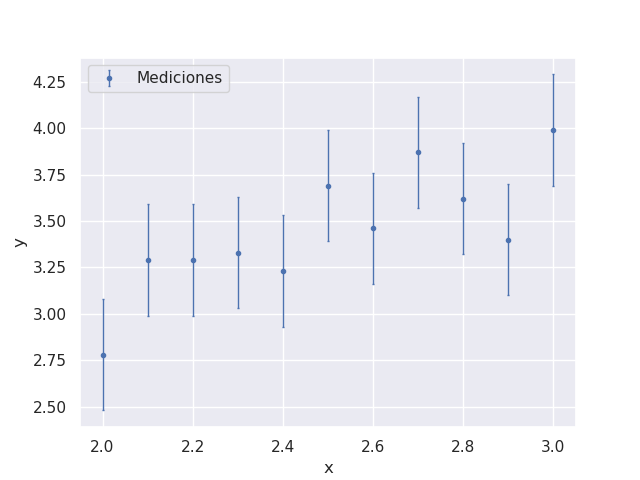

In [16]:
fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=sig_y_vec, fmt='.', elinewidth=1, capsize=0.5, label="Mediciones")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(loc="upper left")
plt.show()

### 2) Ajuste por cuadrados mínimos

Se asume que un modelo lineal $y(x) = a + b x$ reproduce adecuadamente la distribución de los datos. Se pretende, entonces, realizar un ajuste por cuadrador mínimos para obtener los estimadores $\hat{a}$ y $\hat{b}$.

El método de cuadrados mínimos consiste en encontrar los valores de $a$ y $b$ que minimicen a:

\begin{equation}
S_N = \sum_{i=1}^N \left[y_i - (a + bx_i) \right]^2
\end{equation}

Es fácil de demostrar que dichos valores serán:

\begin{align}
\hat{a} &= \frac{1}{\Delta}\left(\sum_i^N x_i^2 \sum_i^N y_i - \sum_i^N x_i \sum_i^N x_iy_i \right) \\
\hat{b} &= \frac{1}{\Delta}\left(N\sum_i^N x_iy_i - \sum_i^N x_i \sum_i^N y_i \right)
\end{align}

siendo $\Delta = N \sum_i^N x_i^2 - \left(\sum_i^N x_i\right)^2$

Claramente los estimadores $\hat{a}$ y $\hat{b}$ dependen de los $y_i$, por lo cual sus incertezas se pueden obtener propagando las incertezas de los $y_i$. El resultado de dicha propagación es:

\begin{equation}
Cov(\hat{a}, \hat{b}) = \frac{\sigma^2}{\Delta}
\begin{bmatrix}
    \sum_i^N x_i^2 & -\sum_i^N x_i \\
    -\sum_i^N x_i & N
\end{bmatrix}
\end{equation}

¿Qué se puede decir sobre la correlación que existe entre $\hat{a}$ y $\hat{b}$? ¿Cómo será su signo? ¿Cuándo se anulará?

Se define la siguiente función para que realice el ajuste y devuelva las estimaciones con su matríz de covarianza:

In [17]:
def ajuste_cm(x, y, sigma_y):
    '''
    Ajusta una recta de la forma y = a + b*x utilizando el método de cuadrados mínimos.
    
    Parámetros:
    -----------
    x : numpy.ndarray
        Valores de la variable independiente (sin errores).
    y : numpy.ndarray
        Valores de la variable dependiente.
    sigma_y : float
        Error estándar de los valores de y (se asume que es el mismo para todos los puntos).
    
    Retorna:
    --------
    a : float
        Ordenada al origen de la recta ajustada.
    b : float
        Pendiente de la recta ajustada.
    cov_ab : numpy.ndarray
        Matriz de covarianza de los parámetros a y b.
    
    '''
    
    # Verificar que x e y tengan el mismo tamaño
    if len(x) != len(y):
        raise ValueError('x e y no tienen el mismo tamaño')
    
    # Convertir a arrays de numpy si no lo son
    x = np.asarray(x)
    y = np.asarray(y)
    
    N = len(x)
    x2 = x**2
    xy = x*y
    
    # Calcular el determinante
    Det = N * x2.sum() - x.sum()**2
    
    # Calcular los parámetros a y b
    a = (x2.sum() * y.sum() - x.sum() * xy.sum()) / Det
    b = (N * xy.sum() - x.sum() * y.sum()) / Det
    
    # Calcular la matriz de covarianza
    cov_ab = (sigma_y**2 / Det) * np.array([[x2.sum(), -x.sum()], [-x.sum(), N]])
   
    return a, b, cov_ab

Se obtienen las estimacioness y se grafica la reacta ajustada:

a_hat = 1.45 +/- 0.72
b_hat = 0.80 +/- 0.29


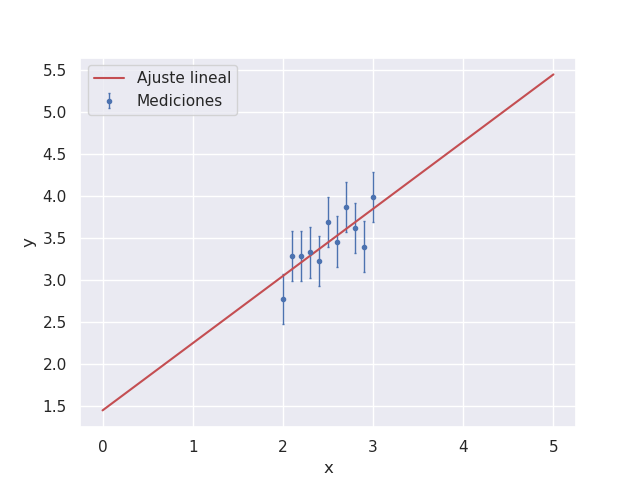

In [18]:
# Ajuste por cuadrados mínimos
a_hat, b_hat, cov_ab = ajuste_cm(x, y, sig_y)

# Se obtiene el desvío estándar de los estimadores 
sig_a_hat, sig_b_hat = np.sqrt(np.diag(cov_ab))

print(f"a_hat = {a_hat:.2f} +/- {sig_a_hat:.2f}")
print(f"b_hat = {b_hat:.2f} +/- {sig_b_hat:.2f}")

# Gráfico
x_fit = np.linspace(0, 5, 100)
y_fit = a_hat + b_hat * x_fit
ax.plot(x_fit, y_fit, 'r', label="Ajuste lineal")
ax.legend(loc="upper left")
plt.show()

### 3) Uso del ajuste para obtener el valor de una nueva medición

Ya se obtuvo la curva de calibración, o sea, los estimadores del modelo lineal $\hat{a}$ y $\hat{b}$.

Ahora se pretende realizar una nueva medición $x_m$ (que se asume sin incerteza), aplicar dicho modelo y obtener el valor $y_m$ con su incerteza $\sigma_{y_m}$.

El valor de $y_m$ se obtiene del modelo:

\begin{equation}
y_m = \hat{a} + \hat{b} x_m
\end{equation}

y su incerteza de aplicar la fórmula de propagación:

\begin{equation}
\sigma_{y_m}^2 = \left(\frac{\partial y_m}{\partial \hat{a}}\right)^2 \sigma^2_{\hat{a}} + \left(\frac{\partial y_m}{\partial \hat{b}}\right)^2 \sigma^2_{\hat{b}} + \frac{\partial y_m}{\partial \hat{a}} \frac{\partial y_m}{\partial \hat{b}} Cov(\hat{a}, \hat{b})
\end{equation}

Realizando la propagación se obtiene:

\begin{equation}
\sigma^2_{y_a} = \frac{\sigma^2}{\Delta}\left(\sum_{i=1}^N x_i^2 + x_m^2 N -2x_m\sum_{i=1}^N x_i\right)
\end{equation}

Se analizará el caso de obtener la incerteza utilizando la fórmula anterior completa (la forma correcta de hacerlo) y el caso de no utilizar el último térmico de la fórmula anterior, es decir, no teniendo en cuenta la correlación entre $\hat{a}$ y $\hat{b}$.

Se define la siguiente función para tal fin:

In [19]:
def sigma_ya(xm, x, y, sig_y):
    """
    Calcula las incertezas de ya al ser evaluado xa en la reacta ajustada por los datos x, y y sig_y
    
    Se calculan los resultados considerando la correlación entre las variables (bien) y sin tener en
    cuenta a la correlación (mal).
    
    Parámetros:
    -----------
    xm : numpy.ndarray
        Valores que se desean evaluar con el ajuste obtenido
    x : numpy.ndarray
        Valores de la variable independiente (sin errores).
    y : numpy.ndarray
        Valores de la variable dependiente.
    sigma_y : float
        Error estándar de los valores de y (se asume que es el mismo para todos los puntos).
    
    Retorna:
    --------
    sig_ym_con_corr : float
        Desvío estándar de 'ym' teniendo en cuenta la correlación del ajuste
    sig_ym_sin_corr : float
        Desvío estándar de 'ym' sin tener en cuenta la correlación del ajuste
    """
    N = len(x)
    x2 = x**2   
    xy = x*y
    
    Det = N*x2.sum()-x.sum()**2 
    
    sig2_ym_con_corr = sig_y / Det * (x2.sum() + N * xm**2 - 2 * x.sum() * xm)
    sig2_ym_sin_corr = sig_y / Det * (x2.sum() + N * xm**2)
    
    return np.sqrt(sig2_ym_con_corr), np.sqrt(sig2_ym_sin_corr)

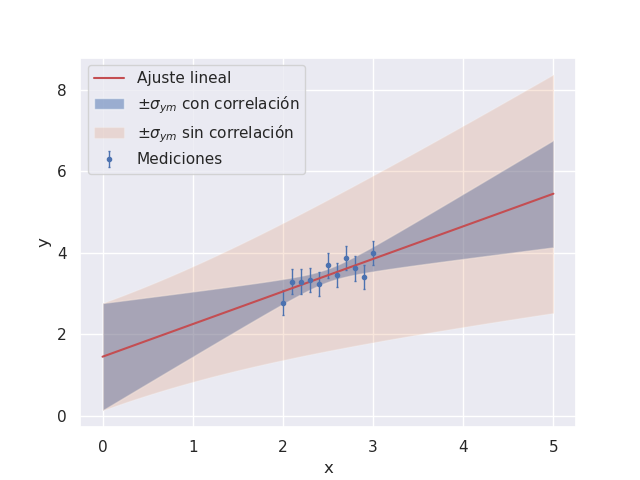

In [20]:
# Se aplica la función anterior para muchos valores de x_a entre x=0 y x=5
xas = np.linspace(0, 5, 100)
sig_ya_con, sig_ya_sin = sigma_ya(xas, x, y, sig_y)
yas = a_hat + b_hat * xas

# Gráficos del resultado de ya con su banda de incerteza (+/- sigma)

# Incerteza correctamente calculada con el término e correlación
ax.fill_between(xas, yas+sig_ya_con, yas-sig_ya_con, alpha=0.5, label=f"$\pm \sigma_{{ym}}$ con correlación")

# Incerteza incorréctamente calculada sin el término e correlación
ax.fill_between(xas, yas+sig_ya_sin, yas-sig_ya_sin, alpha=0.2, label=f"$\pm \sigma_{{ym}}$ sin correlación")

ax.legend(loc="upper left")
plt.show();

Se puede observar que de no considerar el término de correlación, las incerteza obtenida para $y_m$ presenta un comportamiento absurdo, dando su menor valor para $x_m=0$ y luego aumentándo cuadráticamente sin importan la región en donde se realizó las mediciones para la calibración.

Por el contrario, con las incertezas bien calculadas, se obtiene que el valor de $\sigma_{y_m}$ será mínimo justamente cuando se realice una medición en el centro del rango en donde se realizó la calibración.

Usando la expresión obtenida anteriormente para $\sigma_{y_a}(x_a)$ se puede ver que la incerteza mínima $\sigma_{y_a, min}$ se dará en $x_{a,min}$ de acuerdo a:

\begin{align}
x_{m,min} &= \frac{1}{N} \sum_i^N x_i \\
\sigma_{y_m, min} &= \frac{\sigma}{\sqrt{N}}
\end{align}